## Description
Dataset contains nearly 32K tweets which are labeled based on having racist or sexist content. We are going to analyse this dataset and tweets, and by the end, create a classification model to classify tweets.   
Each row in the dataset has 3 columns:
* `id`: Assigned ID to this tweet by Analytics Vidhya.
* `label`: Tweet label, 1 if tweet has hatred content and 0 otherwise.
* `tweet`: Tweet text.  

Dataset is provided by [Analytics Vidhya](http://https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/)  

In [1]:
import numpy as np
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

data = pd.read_csv('../input/train.csv')

How are tweets spread among these 2 classes?

In [2]:
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (data.label == 1).sum(),
    (data.label == 0).sum()
))

Hatred labeled: 2242
Non-hatred labeled: 29720


Classes are pretty much skewed, it's better to use F1 score as evaluation metric.

## Extracting features

#### Hashtags and mentions
We'll extract hashtags for each tweet as an extra column to explore them later.   
For user mentions, all of the usernames have been replaced with `'user'` so we can't get any data from it, we'll just remove mentions and keep the number of mentions in each tweet as an extra features for that tweet.  

In [3]:
hashtags = data['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
data.loc[:, 'hashtags'] = hashtags['hashtag']
data['hashtags'].fillna('', inplace=True)

data.loc[:, 'mentions'] = data['tweet'].str.count('@[a-zA-Z0-9_]+')

data.tweet = data.tweet.str.replace('@[a-zA-Z0-9_]+', '')

#### Removing anything but the words
Now we'll remove anything but the words (punctuations, numbers, etc). Note that this time we'll replace them with a blank space since it might be a `_` or `-` or a punctuation with no space from the next word and we don't want the words to join together.  

In [4]:
data.tweet = data.tweet.str.replace('[^a-zA-Z]', ' ')

#### Lemmatization
We lemmatize tweets' words as we have the sentences and we can tag part of speeches, and will stem hashtags.  

In [5]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, FreqDist, word_tokenize

stemmer = SnowballStemmer('english')
lemmer = WordNetLemmatizer()

part = {
    'N' : 'n',
    'V' : 'v',
    'J' : 'a',
    'S' : 's',
    'R' : 'r'
}

def convert_tag(penn_tag):
    if penn_tag in part.keys():
        return part[penn_tag]
    else:
        return 'n'


def tag_and_lem(element):
    sent = pos_tag(word_tokenize(element))
    return ' '.join([lemmer.lemmatize(sent[k][0], convert_tag(sent[k][1][0]))
                    for k in range(len(sent))])
    

data.loc[:, 'tweet'] = data['tweet'].apply(lambda x: tag_and_lem(x))
data.loc[:, 'hashtags'] = data['hashtags'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


#### Frequent words
Now let's see what words and hashtags are the most frequenst in hate tweets and in total.

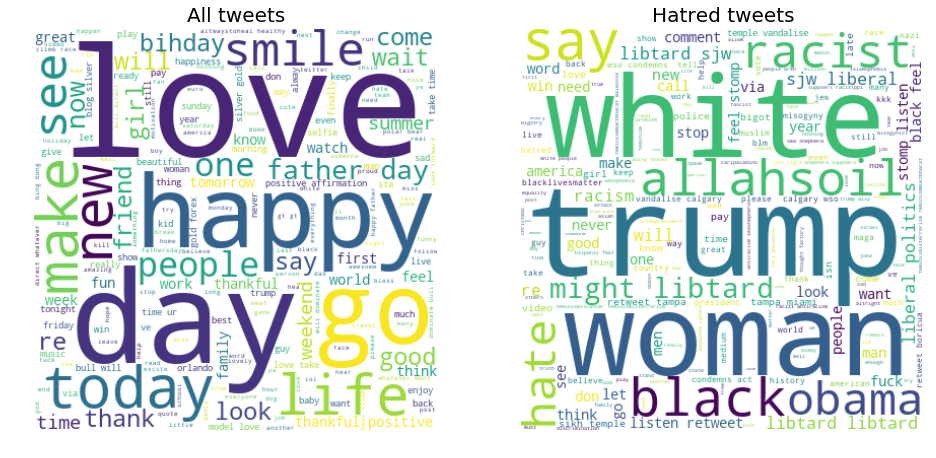

In [6]:
from wordcloud import WordCloud, STOPWORDS
stopwords = STOPWORDS.add('amp')

all_words = ' '.join(data.tweet.values)
hatred_words = ' '.join(data[data.label == 1].tweet.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(all_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('All tweets', size=20)

cloud2 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()

#### Hashtags
Now let's see which hashtags are used the most in hatred tweets and in total.

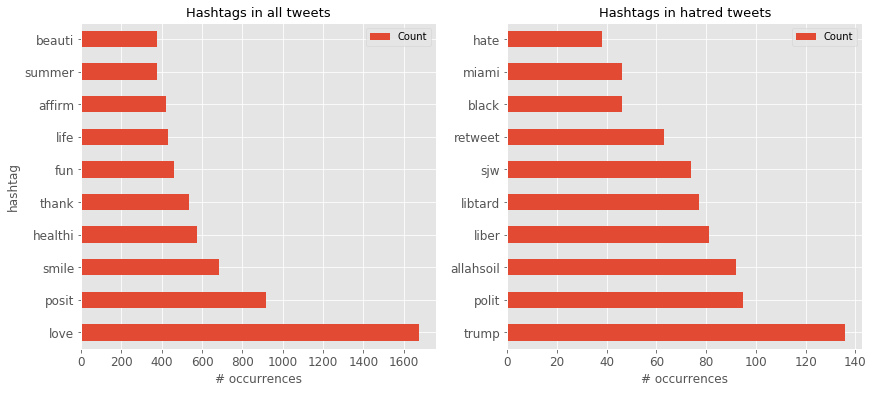

In [7]:
all_hashtags = FreqDist(list(' '.join(data.hashtags.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(data[data.label==1].hashtags.values).split())).most_common(10)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()

#### Mentions
Let's see how many mentions are there in total and if they can be of any use

In [8]:
print("Number of mentions: {}\nNumber of tweets having a mention: {}\nCorrelation with label: {}".format(
    data.mentions.sum(),
    len(data[data.mentions > 0]),
    np.corrcoef(data.mentions, data.label)[0][1]
))

Number of mentions: 17571
Number of tweets having a mention: 11126
Correlation with label: 0.07851491623991766


There is no meaningful relation between number of mentions and it looks like there is not a correlation either. So we'll remove number of mentions and won't use it as a feature.  

In [9]:
data.drop('mentions', axis=1, inplace=True)

#### Tfidf vectorizing
Now we use the frequency of each word in tweets as our features

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), min_df=10)
features = vectorizer.fit_transform(data.tweet)

## Classifying
We'll build a SVC and a LogsiticRegression model for classifying our tweets.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(features, data.label)

#### Logistic Regression

Best parameters found were {'C': 30, 'penalty': 'l2'} with F1 score of 0.64


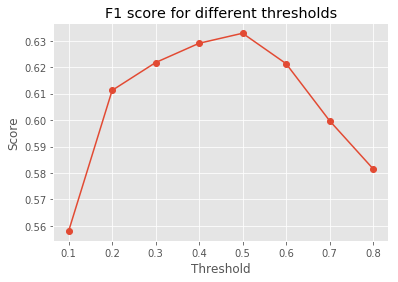

In [12]:
params = {'penalty': ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}
lrmodel = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=150), param_grid=params, scoring='f1', cv=5, n_jobs=-1)
lrmodel.fit(X_train, y_train)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    lrmodel.best_params_,
    lrmodel.best_score_
))
probas = lrmodel.predict_proba(X_test)
thresholds = np.arange(0.1, 0.9, 0.1)
scores = [f1_score(y_test, (probas[:, 1] >= x).astype(int)) for x in thresholds]
plt.plot(thresholds, scores, 'o-')
plt.title("F1 score for different thresholds")
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.show()

Best threshold found for our model is 0.4 so we will label any tweet with probability higher than or equal to 0.4 as hate tweet.

#### SVC

In [13]:
params = {'C': [1000, 3000, 9000, 15000]}
svc = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid=params, scoring='f1', cv=3, n_jobs=-1)
svc.fit(X_train, y_train)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    svc.best_params_,
    svc.best_score_
))
predictions = svc.predict(X_test)
print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_test, predictions)))

Best parameters found were {'C': 9000} with F1 score of 0.62

F1 test score for SVC: 0.65


## Conclusion
We saw some of the most common words and hashtags in general and in racist/sexist tweets, extracted features by counting word tokens and Tfidf weighting them. We used unigrams, bigrams and trigrams as tokens.   
Finally, we built a logistic regression model and a support vector classifier to classify future tweets in these 2 classes.  